## Visualize AMV Prediction Results

Visualizes output from the following scripts and runs

    -ML Baselines (NN_test_lead_ann_ImageNet_classification.py), 10 runs for each architecture
        1) "simplecnn" run
        2) "resnet50" run with unfreezeall=True
        3) "resnet50" run with unfreezeall=False
        4) "FNN2" run
    -AutoML (autosklearn_calc_baseline_metrics.py)
    -Persistence Forecast Baseline (Persistence_Classification_Baseline.py)
    
After running the scripts with the above settings, move the output from "../../CESM_data/Metrics" to "../Data/Metrics/"

Figures are saved to "../Figures/"

In [42]:
import numpy as np
import matplotlib.pyplot as plt
import os
import glob

In [43]:
# Set Paths
fpath      = "../Data/Metrics/"
outfigpath = "../Figures/"

# Settings+Names for labeling/plotting, Data is formatted as [Class1, Class2, Class3]
classes   = ["AMV+","Neutral","AMV-"] # [Class1 = AMV+, Class2 = Neutral, Class3 = AMV-]
leads     = np.arange(0,25,3)
expnames  = ['simplecnn','resnet50(transfer)','resnet50(retrained)',"fnn","fnn4_120","fnn4_128"]
expcolors = ("b","orange","red","fuchsia","cyan","limegreen","gold") # Colors for line plots corresponding to each experiment
baseline  = 0.69476744 # Baseline value to plot

In [44]:
# Some Old Information. Copy and Paste the stuff below if needed:
"""

expname       : "fnn"
descr.        : 2-Layer FNN that takes ImageNet Inputs (224 x 224). Stdev threshold classification.
search string :

flist = glob.glob(fpath+"*FNN2*quant0_*.npz")
flist = [f for f in flist if "resNone" not in f]

---------------

expname       : "fnn_softmax"
descr.        : 2-Layer FNN, original CESM resolution inputs, with softmax layer
search string : 

flist = glob.glob(fpath+"*FNN2*quant0_resNone_softmax*.npz")

---------------

expname       : "fnn4_120_softmax"
descr.        : 4-Layer FNN, original CESM resolution inputs, with softmax layer
search string : 

flist = glob.glob(fpath+"*FNN4_120*quant0_resNone_softmax*.npz")


---------------

expname       : "fnn4_120_nodropout"
descr.        : 4-Layer FNN, original CESM resoultion inputs, no softmax, no dropout
search string : 

flist = glob.glob(fpath+"*FNN4_120_nodrop*quant0_resNone*.npz")

---------------

expname       : 
descr.        : 
search string : 


"""


'\n\nexpname       : "fnn"\ndescr.        : 2-Layer FNN that takes ImageNet Inputs (224 x 224). Stdev threshold classification.\nsearch string :\n\nflist = glob.glob(fpath+"*FNN2*quant0_*.npz")\nflist = [f for f in flist if "resNone" not in f]\n\n---------------\n\nexpname       : "fnn_softmax"\ndescr.        : 2-Layer FNN, original CESM resolution inputs, with softmax layer\nsearch string : \n\nflist = glob.glob(fpath+"*FNN2*quant0_resNone_softmax*.npz")\n\n---------------\n\nexpname       : "fnn4_120_softmax"\ndescr.        : 4-Layer FNN, original CESM resolution inputs, with softmax layer\nsearch string : \n\nflist = glob.glob(fpath+"*FNN4_120*quant0_resNone_softmax*.npz")\n\n\n---------------\n\nexpname       : "fnn4_120_nodropout"\ndescr.        : 4-Layer FNN, original CESM resoultion inputs, no softmax, no dropout\nsearch string : \n\nflist = glob.glob(fpath+"*FNN4_120_nodrop*quant0_resNone*.npz")\n\n---------------\n\nexpname       : \ndescr.        : \nsearch string : \n\n\n'

In [45]:
# Functions
def make_acc_heatmap(accbyclass,leads,title,classes,ax=None):
    """
    Plot heatmap of accuracy by leadtime
    Inputs
    ------
        accbyclass ARRAY [lead x class]
            accuracies by class, for each leadtime
        leads ARRAY [lead]
            array for each leadtime (for labeling ticks)
        title STR
            title for the plot
        classes ARRAY [class]
            name of each class
        ax (optional, default=None)
            axes to plot on. grabs current axes if none is specified
    
    """
    if ax is None:
        ax = plt.gca()
    
    im = ax.imshow(accbyclass[:,:].T,vmin=0.30,vmax=1,cmap='Blues')
    
    # We want to show all ticks...
    ax.set_xticks(np.arange(len(leads)))
    ax.set_yticks(np.arange(len(classes)))
    
    # ... and label them with the respective list entries
    ax.set_xticklabels(leads)
    ax.set_yticklabels(classes)
    ax.set_title(title)
    ax.set_xlabel("Lead Time (Years)")
    fig.colorbar(im,ax=ax,fraction=0.016)
    
    for i in range(len(leads)):
        for j in range(len(classes)):
            if accbyclass[:,:][i,j] > 0.66:
                col = 'w'
            elif accbyclass[:,:][i,j] < 0.33:
                col = 'gray'
            else:
                col = 'k'
            text = ax.text(i, j, "%.2f" % (accbyclass[:,:])[i, j],
                           ha="center", va="center", color=col)
    return ax

def load_result(fn,debug=False):
    """
    Load results for each of the variable names
    
    input: fn (str), Name of the file
    """
    
    ld = np.load(fn,allow_pickle=True)
    vnames = ld.files
    if debug:
        print(vnames)
    output = []
    for v in vnames:
        output.append(ld[v])
    return output,vnames



def retrieve_lead(shuffidx,lead,nens,tstep):
    
    orishape = [nens,tstep-lead]
    outidx   = np.unravel_index(shuffidx,orishape)
    return outidx
    
    

## Load Data

In [46]:
# Read in results

# Preallocate. Some quick definitions:
# model    : Network type [simplecnn,resnet50,resnet50(retrained)]
# run      : Run Number (1 to 10)
# leadtime : Leadtime in years, 0,24 in 3-year steps
totalacc = [] # Accuracy for all classes combined [model x run x leadtime]
classacc = [] # Accuracy by class [model x run x leadtime x class]
ypred    = [] # Predictions [model x run x leadtime x sample]
ylabs    = [] # Labels [model x run x leadtime x sample]
shuffids = [] # Indices [model x run x leadtime x sample]
for m in range(len(expnames)):
    
    #fpath = "../../CESM_data/Metrics/Classification/10run/"
    if m == 0:
        flist = glob.glob(fpath+"*simplecnn*.npz")
    elif m == 1:
        flist = glob.glob(fpath+"*resnet50*unfreeze_allFalse*.npz")
    elif m == 2:
        flist = glob.glob(fpath+"*resnet50*unfreeze_allTrue*.npz")
    elif m == 3:
        flist = glob.glob(fpath+"*FNN2*quant0_resNone*.npz")
        flist = [f for f in flist if "softmax" not in f]

    elif m == 4:
        
        flist = glob.glob(fpath+"*FNN4_120*quant0_resNone*.npz")
        flist = [f for f in flist if "softmax" not in f]
        flist = [f for f in flist if "nodrop" not in f]

    elif m == 5:
        flist = glob.glob(fpath+"*FNN4_128*quant0_resNone*.npz")

    flist.sort()
    print('Found %i files for %s'%(len(flist),expnames[m]))
    
    # Load Result for each model
    totalm    = []
    classm    = []
    ypredm    = []
    ylabsm    = []
    shuffidsm = []
    for i in range(10): # Load for 10 files
        
        output,vnames = load_result(flist[i],debug=False)
        
        
        if len(output[4]) > len(leads):
            print("Selecting Specific Leads!")
            output = [out[leads] for out in output]
            

        totalm.append(output[4])
        classm.append(output[5])
        ypredm.append(output[6])
        ylabsm.append(output[7])
        shuffidsm.append(output[8])
        print("Loaded %s, %s, %s, and %s for run %i, model %s" % (vnames[4],vnames[5],vnames[6],vnames[7],i,expnames[m]))
    
    #print(totalm)
    # Append to array
    totalacc.append(totalm)
    classacc.append(classm)
    ypred.append(ypredm)
    ylabs.append(ylabsm)
    shuffids.append(shuffidsm)

# Turn results into arrays
totalacc = np.array(totalacc) # [model x run x lead]
classacc = np.array(classacc) # [model x run x lead x class]
ypred    = np.array(ypred)    # [model x run x lead x sample] # Last array (tercile based) is not an even sample size...
ylabs    = np.array(ylabs)    # [model x run x lead x sample]
shuffids = np.array(shuffids) # [model x run x lead x sample]
print(vnames)

Found 10 files for simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 0, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 1, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 2, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 3, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 4, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 5, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 6, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 7, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 8, model simplecnn
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 9, model simplecnn
Found 10 files for resnet50(transfer)
Loaded total_acc, acc_by_class, yvalpred, and yvallabels for run 0, model resnet50(transfer)


In [47]:
output[8][:,:].shape

(9, 900)

In [48]:
# Load data from automl results
autopath     = "../Data/Metrics/"
fna          =  'automl_accuracy_t3600_classification.npy'
autodat      = np.load(autopath+fna)
autodattotal = autodat.mean(1) # Calculte mean of 3 classes for total accuracy
autodat.shape

(25, 3)

Text(0.5, 1.0, 'Persistence Baseline')

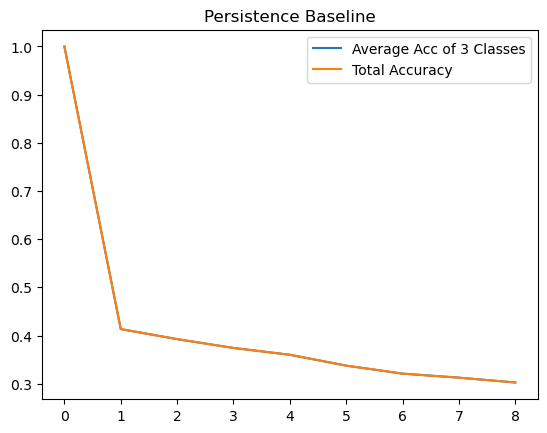

In [49]:
# Load data from persistence baseline
#fnp = "leadtime_testing_ALL_AMVClass3_PersistenceBaseline_1before_nens40_maxlead24_detrend0_noise0_nsample400_ALL_nsamples1.npz"
fnp ="leadtime_testing_ALL_AMVClass3_PersistenceBaseline_1before_nens40_maxlead24_detrend0_noise0_nsample400_limitsamples1_ALL_nsamples1.npz"

ldp = np.load(fpath+fnp,allow_pickle=True)#.f#.arr_0

persaccclass = np.array(ldp['arr_0'][None][0]['acc_by_class']) # [Lead x Class]}
persacctotal = np.array(ldp['arr_0'][None][0]['total_acc'])

# Quick Test Plot
fig,ax = plt.subplots(1,1)
ax.plot(persaccclass.mean(1),label="Average Acc of 3 Classes")
ax.plot(persacctotal,label="Total Accuracy")
ax.legend()
ax.set_title("Persistence Baseline")

## Make Plots

In [50]:
# Set some overhead parameters
lwall = 2.5

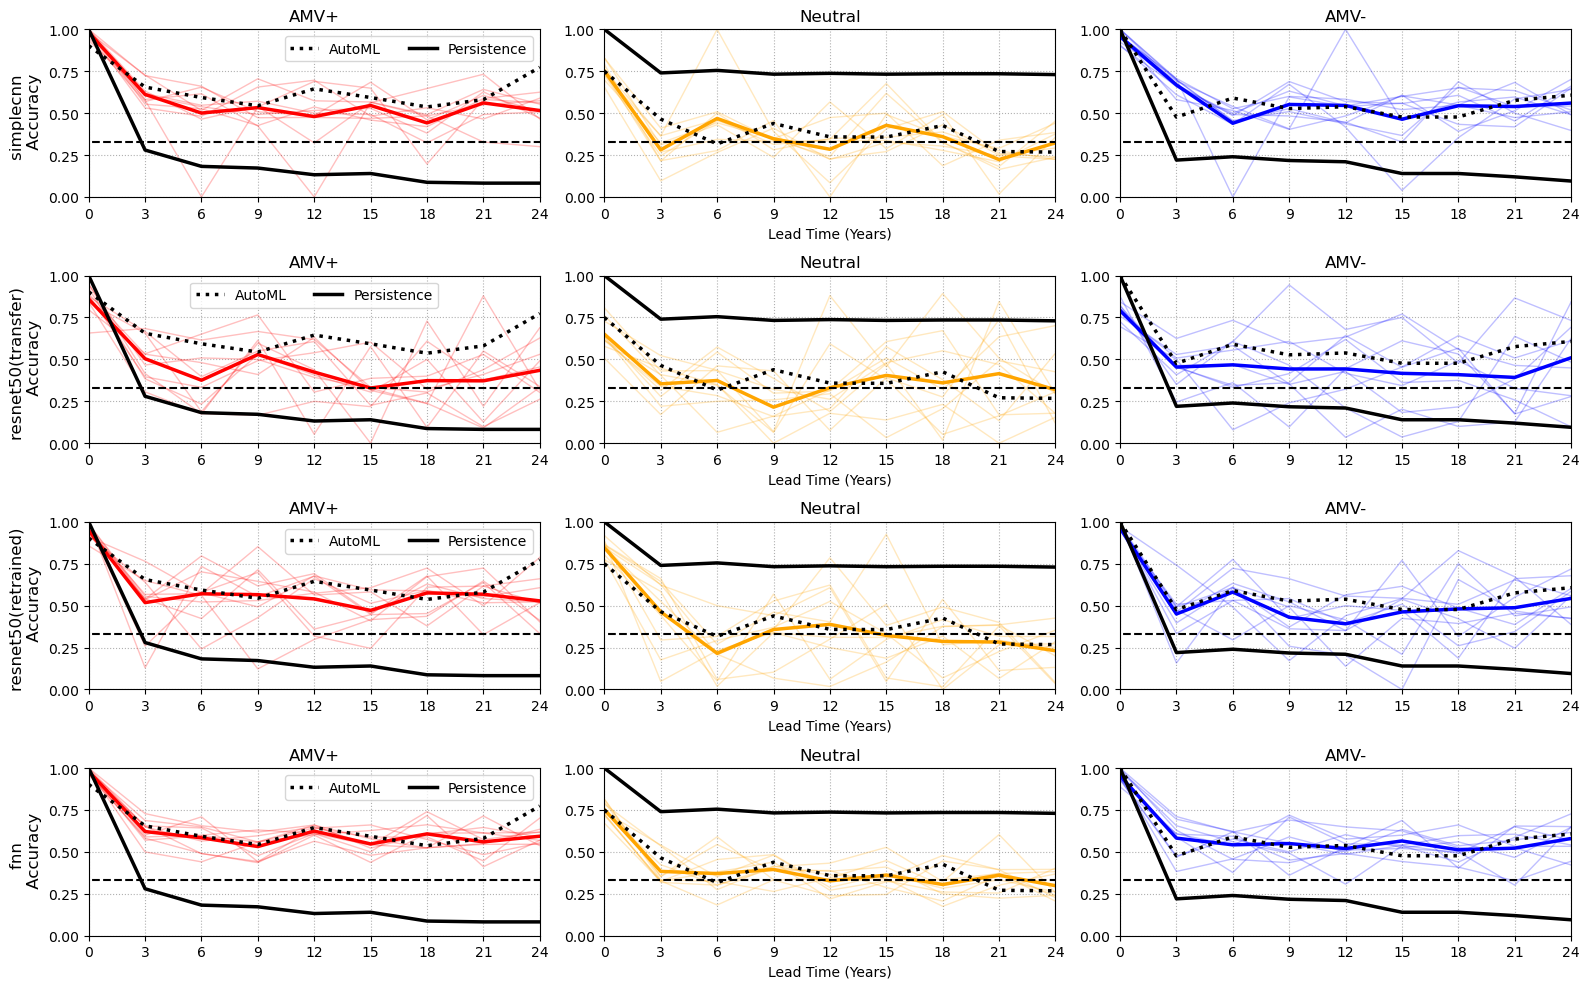

In [38]:
# Plot Accuracy vs Leadtime for each Predictor

classcol = ['r','orange','b']
classnamelong = expnames
fig,axsall = plt.subplots(4,3,figsize=(16,10))


for i in range(4): # Looping for each model type
    
    axs = axsall[i,:]
    for c in range(3):
        ax = axs[c]

        if c == 0:
            ax.set_ylabel("%s \n Accuracy"%classnamelong[i],fontsize=12)
        if c == 1:
            ax.set_xlabel("Lead Time (Years)")

        ax.grid(True,ls='dotted')
        ax.set_xticks(leads)
        ax.set_yticks(np.arange(0,1.25,.25))
        ax.set_xlim(0,24)
        ax.set_title("%s" %(classes[c]),fontsize=12)

        for r in range(10):  
            ax.plot(leads,classacc[i,r,:,c],label="",color=classcol[c],alpha=0.25,lw=1)
        ax.plot(leads,classacc[i,:,:,c].mean(0),color=classcol[c],alpha=1,lw=lwall)
        #ax.plot(np.arange(0,25,1),autodat[:,c],color='k',ls='dotted',label="AutoML")
        ax.plot(leads,autodat[::3,c],color='k',ls='dotted',label="AutoML",lw=lwall)
        ax.plot(leads,persaccclass[:,c],color='k',label="Persistence",lw=lwall)

        ax.hlines([0.33],xmin=-1,xmax=25,ls="dashed",color='k')
        ax.set_ylim([0,1])
        if c == 0:
            ax.legend(fontsize=10,ncol=3)
    #plt.suptitle(expnames[i])
    plt.tight_layout()
plt.savefig("%sFig04_AccbyClass_Leadtime_Horizontal.png"% (outfigpath),dpi=150)

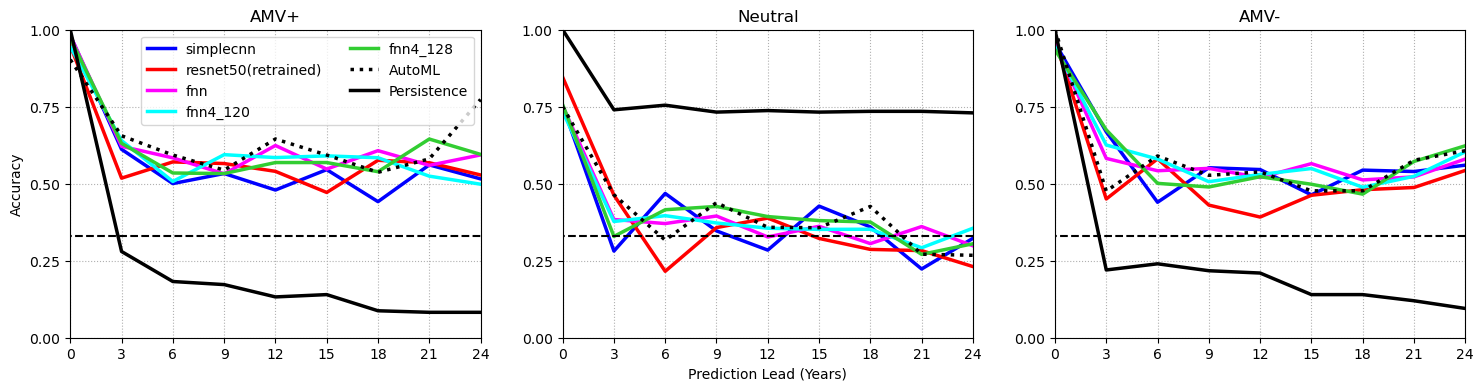

In [51]:
# Compare Between Models by Class

plotmodels = [0,2,3,4,5]

fig,axs = plt.subplots(1,3,figsize=(18,4))

for c in range(3):
    
    # Initialize plot
    ax = axs[c]
    ax.set_title("%s" %(classes[c]),fontsize=12)
    ax.set_xlim([0,24])
    ax.set_xticks(leads)
    ax.set_ylim([0,1])
    ax.set_yticks(np.arange(0,1.25,.25))
    ax.grid(True,ls='dotted')
    
    for i in plotmodels:
        
        ax.plot(leads,classacc[i,:,:,c].mean(0),color=expcolors[i],alpha=1,lw=lwall,label=expnames[i])
    
    ax.plot(leads,autodat[::3,c],color='k',ls='dotted',label="AutoML",lw=lwall)
    ax.plot(leads,persaccclass[:,c],color='k',label="Persistence",lw=lwall)

    ax.hlines([0.33],xmin=-1,xmax=25,ls="dashed",color='k')
        
    if c == 0:
        ax.legend(ncol=2,fontsize=10)
        ax.set_ylabel("Accuracy")
    if c == 1:
        ax.set_xlabel("Prediction Lead (Years)")
        
        
        
plt.savefig("%sModel_Intercomparison_byclass.png"%outfigpath,dpi=200)

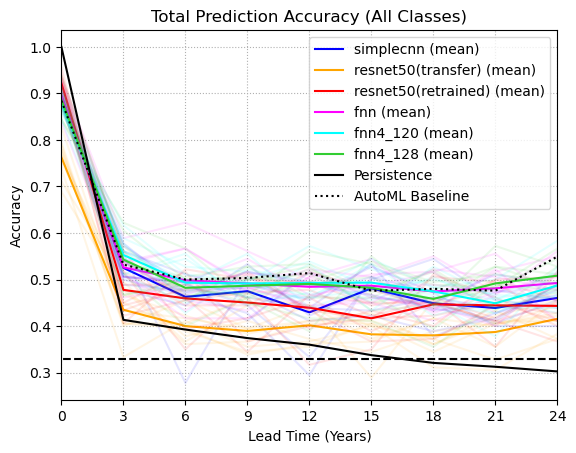

In [52]:
# Plot total accuracy by lead time for each of the 10 runs, comparing each model

fig,ax=plt.subplots(1,1)
ax.grid(True,ls="dotted")
for m in range(len(expnames)): 
    
    ax.plot(leads,totalacc[m,:,:].T,label="",color=expcolors[m],alpha=0.1)
    ax.plot(leads,totalacc[m,:,:].mean(0),label="%s (mean)"%expnames[m],color=expcolors[m])

#ax.plot()

ax.plot(leads,persacctotal,color='k',label="Persistence")
ax.plot(leads,autodattotal[::3],color='k',label="AutoML Baseline",ls='dotted')
ax.legend()
ax.set_title("Total Prediction Accuracy (All Classes)")
ax.hlines([0.33],xmin=-1,xmax=26,ls='dashed',color='k')
ax.set_xlim([0,24])
ax.set_ylabel("Accuracy")
ax.set_xlabel("Lead Time (Years)")
ax.set_xticks(leads)
plt.savefig("%sTotalPredAcc.png"%outfigpath,dpi=200)

In [11]:
expcolors

('b', 'orange', 'red', 'fuchsia')

In [12]:
# Try Unraveling Indices

# Get the Model
m     = 2 # Model
nr    = 0 # Run
l     = 0 # Leadtime

# Get the original indices of the shuffled variables
ids           = shuffids[m,nr,l,:]
nens          = 40
tstep         = 86
idens,idtime  = retrieve_lead(ids.astype(int),leads[l],nens,tstep)

In [13]:
ypred.shape
ylabs.shape

(4, 10, 9, 180)

In [14]:
.20 * 900

180.0

In [15]:
ids.shape, ypred.shape, ylabs.shape

((900,), (4, 10, 9, 180), (4, 10, 9, 180))

In [16]:
idens.shape,idtime.shape

((900,), (900,))

In [2]:
ls -l

total 1344
-rw-r--r--@ 1 gliu  staff  684178 Jul 29 17:48 viz_results.ipynb


In [3]:
chmod 755 viz_results.ipynb

SyntaxError: invalid syntax (<ipython-input-3-ebe0d87b7388>, line 1)

In [5]:
import os
os.getcwd()

'/Users/gliu/Downloads/02_Research/01_Projects/04_Predict_AMV/03_Scripts/predict_amv/Analysis'